Housing Price Prediction Project (Tehran)

Author: **Reza Adousi**

Date: **2025**

Description:

This is my first Machine Learning project, created as a simple educational exercise.
The goal of this project is to predict house prices in Tehran based on various features
such as area, number of rooms, Addresses and amenities. This project demonstrates:
- Data cleaning and preprocessing
- Feature engineering
- Model building (Linear Regression, Decision Tree, Random Forest)
- Model evaluation (R2, MAPE)

Important Notes:
- The dataset contains real housing data, but it is limited and simplified.
- This simple project is for educational purposes only and is not suitable for
  decision-making or financial use.
- Since this is a beginner project, there may be errors or suboptimal steps in the process.
- The code is meant to help me (and others) learn the basics of data preprocessing,
  exploratory analysis, and regression modeling in Python.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
housing = pd.read_csv("housePrice.csv")

In [3]:
housing.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


Remove rows with missing values and ensure 'Area' column is numeric:

In [5]:
housing.dropna(axis=0,inplace=True)
housing['Area'] = pd.to_numeric(housing['Area'],errors='coerce')
housing["Area"] = housing['Area'].fillna(housing['Area'].median())

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3456 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3456 non-null   float64
 1   Room        3456 non-null   int64  
 2   Parking     3456 non-null   bool   
 3   Warehouse   3456 non-null   bool   
 4   Elevator    3456 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3456 non-null   float64
 7   Price(USD)  3456 non-null   float64
dtypes: bool(3), float64(3), int64(1), object(1)
memory usage: 172.1+ KB


Here I attempted to convert USD prices to IRR using API, but faced issues; we'll predict IRR directly from the dataset instead. although it's outdated.

In [7]:
import requests

url = "https://api.alanchand.com/?type=currencies&token=W9vnxID7CUbCSlHLoac7"
response = requests.get(url).json()

usd_sell = response["usd"]["sell"]

#housing["Price"] = housing["Price(USD)"] * usd_sell
housing = housing.drop(['Price(USD)'],axis=1)

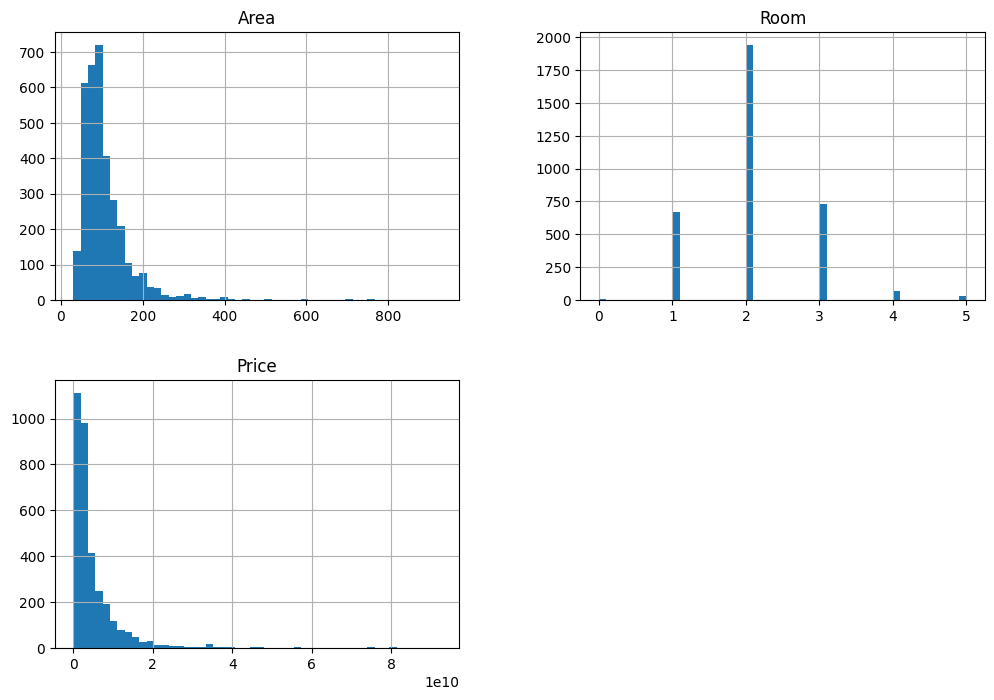

In [8]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

Used boxplots to visualize and remove extreme outliers in 'Area' and 'Price' columns.


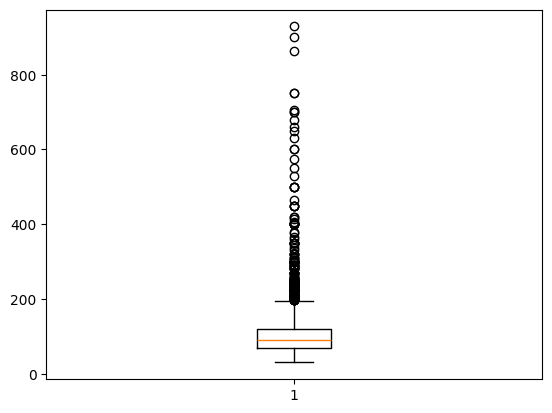

In [9]:
plt.boxplot(housing['Area'])
plt.show()

In [10]:
housing = housing[housing["Area"] <= 200]

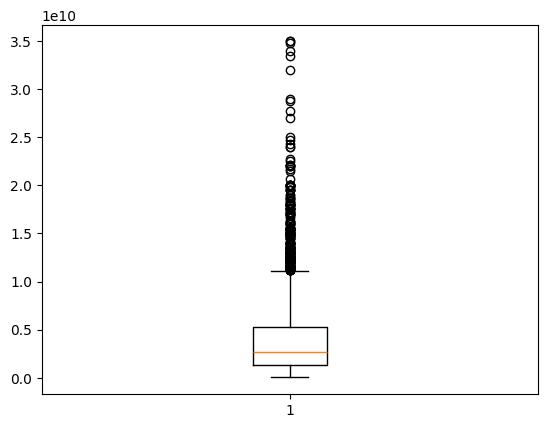

In [11]:
plt.boxplot(housing['Price'])
plt.show()

In [12]:
housing = housing[housing["Price"] <= 1.3 * 1e11]

In [13]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["Price"].sort_values(ascending=False)

,Price
Price,1.000000
Area,0.740074
Room,0.539848
Parking,0.275469
Elevator,0.259112
Warehouse,0.161962


We can create new features such as:
1. Total_Amenities: sum of Parking, Elevator, and Warehouse (binary features).
2. Area_per_Address: average area per neighborhood, used to capture local trends.

These new features might improve model performance.

In [14]:
housing['Total_Amenities'] = housing['Parking'].astype(int) + housing['Elevator'].astype(int) + housing['Warehouse'].astype(int)
housing['Area_per_Address'] = housing.groupby('Address')['Area'].transform('mean')

In [15]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["Price"].sort_values(ascending=False)

,Price
Price,1.000000
Area,0.740074
Area_per_Address,0.688663
Room,0.539848
Total_Amenities,0.313918
Parking,0.275469
Elevator,0.259112
Warehouse,0.161962


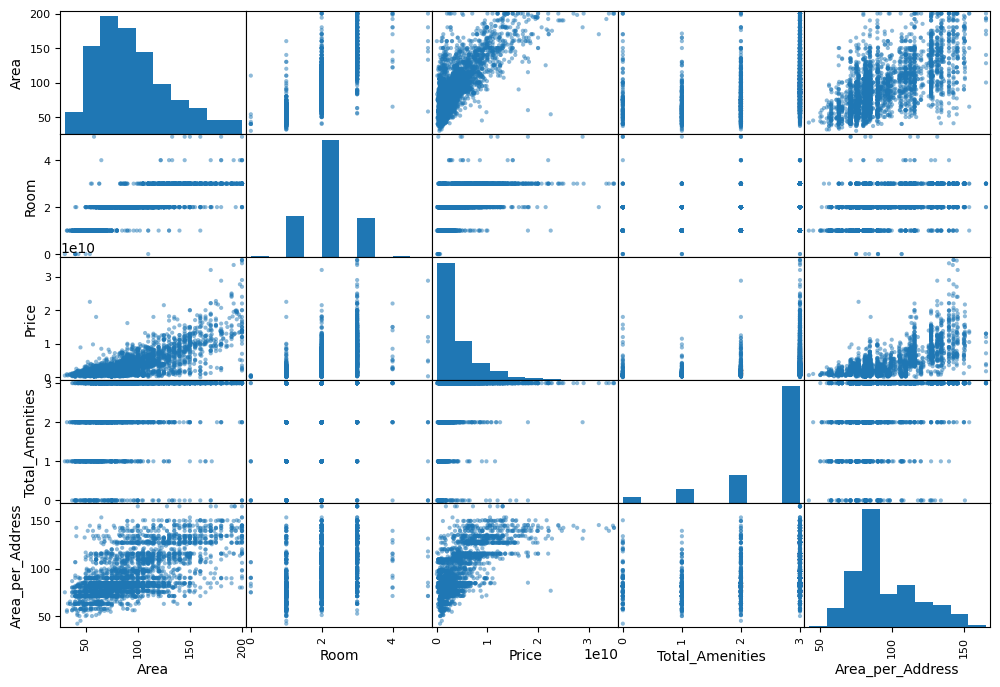

In [16]:
from pandas.plotting import scatter_matrix
attributes = ["Area", "Room", "Price", "Total_Amenities", "Area_per_Address"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

We remove duplicated rows to avoid data leakage


In [17]:
housing = housing.drop_duplicates()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3062 entries, 0 to 3478
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              3062 non-null   float64
 1   Room              3062 non-null   int64  
 2   Parking           3062 non-null   bool   
 3   Warehouse         3062 non-null   bool   
 4   Elevator          3062 non-null   bool   
 5   Address           3062 non-null   object 
 6   Price             3062 non-null   float64
 7   Total_Amenities   3062 non-null   int64  
 8   Area_per_Address  3062 non-null   float64
dtypes: bool(3), float64(3), int64(2), object(1)
memory usage: 176.4+ KB


For simplification, we keep only the Total_Amenities feature instead of the three boolean columns
(Parking, Elevator, Warehouse), since they show similar correlation with Price.
We also keep Area_per_Address because it shows a relatively high correlation with Price.

In [18]:
X = housing.drop(['Price', 'Address', 'Parking', 'Warehouse', 'Elevator'], axis=1)
y = housing['Price'].copy()
X.describe()

,Area,Room,Total_Amenities,Area_per_Address
count,3062.000000,3062.000000,3062.000000,3062.000000
mean,95.005879,2.003592,2.543109,94.825086
std,35.968469,0.670701,0.803417,23.075578
min,30.000000,0.000000,0.000000,42.000000
25%,68.000000,2.000000,2.000000,79.986301
50%,88.000000,2.000000,3.000000,85.073394
75%,115.000000,2.000000,3.000000,112.071429
max,200.000000,5.000000,3.000000,165.444444


In [19]:
y.describe()

,Price
count,3.062000e+03
mean,4.135417e+09
std,4.223785e+09
min,3.600000e+06
25%,1.318500e+09
50%,2.720000e+09
75%,5.400000e+09
max,3.500000e+10


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2449 entries, 2319 to 972
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Area              2449 non-null   float64
 1   Room              2449 non-null   int64  
 2   Total_Amenities   2449 non-null   int64  
 3   Area_per_Address  2449 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 95.7 KB


In [ ]:
X_test.info()

We try two approaches for pipelines:
- Scaled: for models that need feature scaling (Linear Regression)
- Unscaled: for tree-based models (Decision Tree, Random Forest)
Fit each model and evaluate using R2 score.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [23]:
pipeline_scaled = Pipeline([("scaler", StandardScaler()), ("lin_reg", LinearRegression())])

pipeline_scaled.fit(X_train, y_train)
pred_scaled = pipeline_scaled.predict(X_test)
r2_LR = r2_score(y_test, pred_scaled)

In [24]:
pipeline_tree = Pipeline([("tree_reg", DecisionTreeRegressor(random_state=42))])

pipeline_tree.fit(X_train, y_train)
pred_tree = pipeline_tree.predict(X_test)
r2_DT = r2_score(y_test, pred_tree)

In [25]:
pipeline_rf = Pipeline([("forest_reg", RandomForestRegressor(random_state=42))])

pipeline_rf.fit(X_train, y_train)
pred_rf = pipeline_rf.predict(X_test)
r2_RF = r2_score(y_test, pred_rf)

In [26]:
print(f"Linear Regression R2 Score: {r2_LR:.4f}")
print(f"Decision Tree R2 Score: {r2_DT:.4f}")
print(f"Random Forest R2 Score: {r2_RF:.4f}")

Linear Regression R2 Score: 0.6618
Decision Tree R2 Score: 0.6368
Random Forest R2 Score: 0.7725


Random Forest performs best. We further optimize it using RandomizedSearchCV
to find the best combination of hyperparameters.

In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'forest_reg__n_estimators': [50, 100, 200, 300],
    'forest_reg__max_depth': [None, 10, 20],
    'forest_reg__max_features': ['auto', 'sqrt'],
    'forest_reg__min_samples_split': [2, 5, 10],
    'forest_reg__min_samples_leaf': [1, 2, 4]
}

rf_pipeline = Pipeline([("forest_reg", RandomForestRegressor(random_state=42))])

random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

pred_best = best_model.predict(X_test)
r2_best = r2_score(y_test, pred_best)

print("\nBest Random Forest Model:", random_search.best_params_)
print(f"Best Random Forest R2 Score: {r2_best:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
80 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l


Best Random Forest Model: {'forest_reg__n_estimators': 300, 'forest_reg__min_samples_split': 5, 'forest_reg__min_samples_leaf': 2, 'forest_reg__max_features': 'sqrt', 'forest_reg__max_depth': 20}
Best Random Forest R2 Score: 0.7967


In [32]:
pred_best[:10]

array([2.79226226e+09, 1.09516142e+10, 1.64631640e+09, 3.04735177e+09,
       2.38754819e+09, 1.01260851e+09, 2.31292447e+09, 2.64892024e+09,
       7.75031276e+09, 5.94432514e+09])

In [33]:
y_test[:10]

,Price
2013,4.780000e+09
219,1.300000e+10
1542,1.450000e+09
1654,3.900000e+09
1789,2.150000e+09
112,5.450000e+08
3225,2.300000e+09
3292,2.150000e+09
554,1.300000e+10
1638,5.580000e+09


MAPE shows prediction accuracy in percentage

In [37]:
mape = np.mean(np.abs((y_test - pred_best) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 44.10%
